In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri May  7 16:22:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


# Data Download

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
import torch.utils.data
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
import torch.tensor as tensor
import time
import copy
from torchvision import models, transforms
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
from PIL import Image

from __future__ import print_function
import numpy as np
import argparse
import torch.utils.data as data_utils
import torch.optim as optim
from torch.autograd import Variable
import tensorflow as tf
import datetime, os

cuda = torch.device('cuda')

In [ ]:
# !pip install googledrivedownloader
# from google_drive_downloader import GoogleDriveDownloader as gdd
# gdd.download_file_from_google_drive(file_id='13vFqjgBqTWLuBwAVSOmZ8HotckfIZjor',
#                                     dest_path='/tmp/tcga/filtered.zip',
#                                     unzip=True)
# !rm /tmp/tcga/filtered.zip

# https://drive.google.com/file/d/1SmsFlYp2CHndQ4Jx_ngHtQfzIT6_4wfO/view?usp=sharing
!pip install googledrivedownloader
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1SmsFlYp2CHndQ4Jx_ngHtQfzIT6_4wfO',
                                    dest_path='/tmp/tcga/filtered.zip',
                                    unzip=True)
!rm /tmp/tcga/filtered.zip

Unzipping...Done.


In [ ]:
# from google_drive_downloader import GoogleDriveDownloader as gdd
# gdd.download_file_from_google_drive(file_id='1WCQ8l-Q-BAGnOczwMXWtmtHySvROaC14',
#                                     dest_path='/tmp/tcga/has_been_moved_and_filtered',
#                                     unzip=False)

from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1ae3IfTucMSsUNEnC-HNbAaycDjIkI1T0',
                                    dest_path='/tmp/tcga/has_been_moved_and_filtered',
                                    unzip=False)

In [ ]:
# filtered_tiles_output_folder = /tmp/tcga/filtered_tiles/
has_been_filtered_filename = "/tmp/tcga/has_been_moved_and_filtered"
data_folders = open(has_been_filtered_filename, 'r').read().splitlines()

In [ ]:
slides_folders = list(map(lambda f: os.path.join("/tmp/tcga/", f.replace("/Users/shunshao/Documents/GitHub/tcga_segmentation/output_folder/", "/tmp/tcga/")), data_folders))

In [ ]:
len(slides_folders)

49

In [ ]:
slides_folders

['/tmp/tcga/filtered_tiles/TCGA-BP-4969-11A-01-TS1.c1c429b7-7769-48b5-b3fd-3dce5aa4c19a.svs',
 '/tmp/tcga/filtered_tiles/TCGA-CW-5585-01A-01-TS1.08dbf72d-9d28-4267-89d6-bfab37f33096.svs',
 '/tmp/tcga/filtered_tiles/TCGA-AK-3460-01A-02-BS2.effbb5e1-726b-426b-a060-5fdc565fadb9.svs',
 '/tmp/tcga/filtered_tiles/TCGA-A3-3387-01A-01-TS1.d0719d8d-1e96-407f-b647-06171061db34.svs',
 '/tmp/tcga/filtered_tiles/TCGA-A3-3365-01Z-00-DX1.dc5b8d77-b5ba-47c8-b536-a8f1ed458ed3.svs',
 '/tmp/tcga/filtered_tiles/TCGA-A3-3352-01A-01-TS1.d3c4f914-3145-4f6c-911f-46fd569589d1.svs',
 '/tmp/tcga/filtered_tiles/TCGA-B8-4620-01A-01-TS1.f45ec4b6-52aa-496a-b047-3665a98a448f.svs',
 '/tmp/tcga/filtered_tiles/TCGA-AK-3447-01A-01-BS1.d736ff05-4908-447f-8b63-334a59540b82.svs',
 '/tmp/tcga/filtered_tiles/TCGA-B0-5121-11A-01-TS1.01317588-26dd-4337-86c0-d3bfcf066c23.svs',
 '/tmp/tcga/filtered_tiles/TCGA-B8-5552-01B-01-TS1.7cfbbaef-3cf6-4ea1-825e-b521d282b9ab.svs',
 '/tmp/tcga/filtered_tiles/TCGA-AS-3777-01A-01-BS1.5a03479b-

# 2. Build the dataset

In [ ]:
# Dataset
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


class Dataset(torch.utils.data.dataset.Dataset):
    def __init__(self, slides_folders, model_input_size, is_training, max_bag_size, logger, max_dataset_size=None,
                 with_data_augmentation=True, seed=123, normalization_mean=None, normalization_std=None):
        """
        :param slides_folders: list of abs paths of slide folder (which should contains images, summary/label/percent
            files
        :param model_input_size: expected model input size (for cropping)
        :param is_training: True if is training, else False (for data augmentation)
        :param max_bag_size: maximum number of instances to be returned per bag
        """

        def verify_slide_folder_exists(slide_folder):
            if not os.path.exists(slide_folder):
                raise FileExistsError('parent dataset folder %s does not exist' % slide_folder)

        list(map(verify_slide_folder_exists, slides_folders))

        # self.slides_folders = np.asarray(slides_folders)
        self.slides_folders = slides_folders
        self.model_input_size = model_input_size
        self.max_bag_size = max_bag_size
        self.max_dataset_size = max_dataset_size

        self.is_training = is_training

        # self.logger = logger

        self.slides_ids = []  # ids slides
        self.slides_labels = []  # raw str labels
        self.slides_summaries = []  # list of all initial tiles of slides
        self.slides_cases = []  # list of all cases IDs
        self.slides_images_filepaths = []  # list of all in-dataset tilespaths of slides

        self.with_data_augmentation = with_data_augmentation
        normalization_mean = (0, 0, 0) if normalization_mean is None else normalization_mean
        normalization_std = (1, 1, 1) if normalization_std is None else normalization_std
        self.transform = self._define_data_transforms(normalization_mean, normalization_std)

        self.seed = seed

        slides_ids, slides_labels, slides_summaries, slides_cases, slides_images_filepaths = self.load_data()
        self.slides_ids = slides_ids
        self.slides_labels = slides_labels
        self.slides_summaries = slides_summaries
        self.slides_cases = slides_cases
        self.slides_images_filepaths = slides_images_filepaths

        assert len(self.slides_ids) == len(self.slides_labels) == len(self.slides_summaries) == \
               len(self.slides_images_filepaths), 'mismatch in slides containers lengths %s' % (
            ' '.join(str(len(l)) for l in [self.slides_ids, self.slides_labels, self.slides_summaries,
                                           self.slides_images_filepaths]))

        self.retrieve_tiles_ids_with_images = False  # True will return bag of images and associated tiles ids

    def _define_data_transforms(self, mean, std):
        if self.with_data_augmentation:
            return transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.ColorJitter(0.1, 0.1, 0.1, 0.01),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ])
        return transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

    def load_data(self):
        slides_ids, slides_labels, slides_summaries, slides_cases, slides_images_filepaths = [], [], [], [], []

        # Name of expected non-image files for all slides folders
        label_filename = 'label.txt'
        case_id_filename = 'case_id.txt'
        summary_filename = 'summary.txt'

        # Seek all slides folders, and load static data including list of tiles filepaths and bag label
        for i, slide_folder in enumerate(tqdm(self.slides_folders)):
            if self.max_dataset_size is not None and i + 1 > self.max_dataset_size:
                break
            # print(slide_folder)
            # a = filter(lambda f: os.path.isfile(os.path.join(slide_folder, f)), os.listdir(slide_folder))
            # print(a)
            # b = list(a)
            all_slide_files = list(filter(lambda f: os.path.isfile(os.path.join(slide_folder, f)),
                                          os.listdir(slide_folder)))

            # Seek and save label, case_id and summary files: expects 1 and only 1 for each
            for data_filename in [label_filename, case_id_filename, summary_filename]:
                assert sum([f == data_filename for f in all_slide_files]) == 1, \
                    'slide %s: found %d files for %s, expected 1' % (slide_folder,
                                                                     sum([f == data_filename for f in
                                                                          all_slide_files], ),
                                                                     data_filename)

            label_file = os.path.join(slide_folder, [f for f in all_slide_files if f == label_filename][0])
            case_id_file = os.path.join(slide_folder, [f for f in all_slide_files if f == case_id_filename][0])
            summary_file = os.path.join(slide_folder, [f for f in all_slide_files if f == summary_filename][0])
            with open(label_file, 'r') as f:
                slide_label = int(f.read())
            with open(case_id_file, 'r') as f:
                slide_case_id = f.read()
            with open(summary_file, 'r') as f:
                slide_original_tiles = f.read().splitlines()

            # Seek all filtered images of slide (not-background images)
            slide_images_filenames = list(filter(lambda f: f.endswith(('.jpeg', '.jpg', '.png')), all_slide_files))

            if len(slide_images_filenames) == 0:
                self.logger.warning('Discarding slide %s of class %d because there are no images' %
                                    (slide_folder, slide_label))
                continue

            # Save data
            slides_ids.append(os.path.basename(slide_folder))
            slides_labels.append(slide_label)
            slides_summaries.append(slide_original_tiles)
            slides_cases.append(slide_case_id)
            slides_images_filepaths.append(
                list(map(lambda f: os.path.abspath(os.path.join(slide_folder, f)), slide_images_filenames)))

        slides_ids = np.asarray(slides_ids)
        slides_labels = np.asarray(slides_labels)
        print("end\n")

        return slides_ids, slides_labels, slides_summaries, slides_cases, slides_images_filepaths

    # def show_bag(self, bag_idx, savefolder=None):
    #     """ Plot/save tiles sampled from the slide of provided index """
    #     bag = self._get_slide_instances(bag_idx)
    #     bag_label = self.slides_labels[bag_idx]
    #     tr = transforms.ToTensor()
    #     bag = [tr(b) for b in bag]
    #     imgs = make_grid(bag)

    #     npimgs = imgs.numpy()
    #     plt.imshow(np.transpose(npimgs, (1, 2, 0)), interpolation='nearest')
    #     plt.title('Bag label: %s | %d instances' % (bag_label, len(bag)))
    #     if savefolder is not None:
    #         plt.savefig(os.path.join(savefolder, 'show_' + str(bag_idx) + '.png'), dpi=1000)
    #     else:
    #         plt.show()

    def _get_slide_instances(self, item):
        """ Memory load all tiles or randomly sampled tiles from slide of specified index """
        slide_images_filepaths = self.slides_images_filepaths[item]

        # Randomly sample the specified max number of tiles from the slide with replacement
        if self.max_bag_size is not None:
            slide_images_filepaths = random.choices(slide_images_filepaths, k=self.max_bag_size)

        # Load images
        bag_images = [pil_loader(slide_image_filepath) for slide_image_filepath in slide_images_filepaths]

        if self.retrieve_tiles_ids_with_images:
            # return bag of images as well as the associated ids of the tiles
            return bag_images, list(map(os.path.basename, slide_images_filepaths)), self.slides_summaries[item]
        return bag_images

    def __getitem__(self, item):
        if not self.retrieve_tiles_ids_with_images:
            slide_instances = self._get_slide_instances(item)
            slide_instances = torch.stack([self.transform(instance) for instance in slide_instances])
            slide_label = self.slides_labels[item]
            return slide_instances, slide_label

        slide_instances, tiles_ids, slide_summary = self._get_slide_instances(item)
        slide_instances = torch.stack([self.transform(instance) for instance in slide_instances])
        slide_label = self.slides_labels[item]
        return slide_instances, slide_label, tiles_ids, slide_summary

    def __len__(self):
        return len(self.slides_labels)

In [ ]:
import random

def split_svs_samples_casewise(svs_files, associated_cases_ids, val_size, test_size, seed=123):
    assert len(svs_files) == len(associated_cases_ids), 'Expected same number of SVS files than associated case ID'
    random.seed(seed)
    train_size = 1. - val_size - test_size

    unique_cases_ids = list(set(associated_cases_ids))
    random.shuffle(unique_cases_ids)
    total_unique_cases_ids = len(unique_cases_ids)

    # Extract cases ids for training, validation and testing sets
    train_cases_ids = unique_cases_ids[:int(train_size*total_unique_cases_ids)]
    val_cases_ids = unique_cases_ids[int(train_size*total_unique_cases_ids):
                                     int(train_size*total_unique_cases_ids)+int(val_size*total_unique_cases_ids)]
    test_cases_ids = unique_cases_ids[int(train_size*total_unique_cases_ids)+int(val_size*total_unique_cases_ids):]
    assert len(train_cases_ids) + len(val_cases_ids) + len(test_cases_ids) == total_unique_cases_ids

    # Compute associated split set for SVS files
    train_svs_files, val_svs_files, test_svs_files = [], [], []
    for svs_file, associated_case_id in zip(svs_files, associated_cases_ids):
        if associated_case_id in train_cases_ids:
            train_svs_files.append(svs_file)
        elif associated_case_id in val_cases_ids:
            val_svs_files.append(svs_file)
        else:
            test_svs_files.append(svs_file)

    return train_svs_files, val_svs_files, test_svs_files

def build_datasets(source_slides_folders, model_input_width, hyper_parameters, logger):
    normalization_channels_mean = (0.6387467, 0.51136744, 0.6061169)
    normalization_channels_std = (0.31200314, 0.3260718, 0.30386254)

    # First load all data into a single Dataset
    whole_dataset = Dataset(slides_folders=source_slides_folders, model_input_size=model_input_width,
                            is_training=False, max_bag_size=hyper_parameters['max_bag_size'],
                            logger=logger, max_dataset_size=hyper_parameters['dataset_max_size'],
                            with_data_augmentation=hyper_parameters['with_data_augmentation'],
                            seed=hyper_parameters['seed'],
                            normalization_mean=normalization_channels_mean,
                            normalization_std=normalization_channels_std)
    whole_cases_ids = whole_dataset.slides_cases
    whole_indexes = list(range(len(whole_dataset)))

    val_size = hyper_parameters['val_size']
    test_size = hyper_parameters['test_size']
    train_idx, val_idx, test_idx = split_svs_samples_casewise(whole_indexes, whole_cases_ids,
                                                              val_size=val_size, test_size=test_size,
                                                              seed=hyper_parameters['seed'])

    val_dataset = torch.utils.data.Subset(whole_dataset, val_idx)
    test_dataset = torch.utils.data.Subset(whole_dataset, test_idx)
    train_dataset = torch.utils.data.Subset(whole_dataset, train_idx)
    train_dataset.dataset.is_training = True
    train_dataset.dataset.transform = train_dataset.dataset._define_data_transforms(normalization_channels_mean,
                                                                                    normalization_channels_std)

    return train_dataset, val_dataset, test_dataset, whole_cases_ids, whole_indexes, whole_dataset

# 1.Review on Resnet

In [ ]:
rn18 = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
children_counter = 0
for n,c in rn18.named_children():
    print("Children Counter: ",children_counter," Layer Name: ",n,)
    children_counter+=1

Children Counter:  0  Layer Name:  conv1
Children Counter:  1  Layer Name:  bn1
Children Counter:  2  Layer Name:  relu
Children Counter:  3  Layer Name:  maxpool
Children Counter:  4  Layer Name:  layer1
Children Counter:  5  Layer Name:  layer2
Children Counter:  6  Layer Name:  layer3
Children Counter:  7  Layer Name:  layer4
Children Counter:  8  Layer Name:  avgpool
Children Counter:  9  Layer Name:  fc


In [ ]:
rn18._modules

OrderedDict([('conv1',
              Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)),
             ('bn1',
              BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
             ('relu', ReLU(inplace=True)),
             ('maxpool',
              MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)),
             ('layer1', Sequential(
                (0): BasicBlock(
                  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (relu): ReLU(inplace=True)
                  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                )
                (1): BasicBlock(
                  (conv

In [ ]:
class new_model(nn.Module):
    def __init__(self,output_layer = None):
        super().__init__()
        self.pretrained = models.resnet18(pretrained=True)
        self.output_layer = output_layer
        self.layers = list(self.pretrained._modules.keys())
        self.layer_count = 0
        for l in self.layers:
            if l != self.output_layer:
                self.layer_count += 1
            else:
                break
        for i in range(1,len(self.layers)-self.layer_count):
            self.dummy_var = self.pretrained._modules.pop(self.layers[-i])
        
        self.net = nn.Sequential(self.pretrained._modules)
        self.pretrained = None

    def forward(self,x):
        x = self.net(x)
        return x

In [ ]:
model = new_model(output_layer = 'layer4')
cuda = torch.device('cuda:0')
model = model.to(cuda)

In [ ]:
summary(model,input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
print(model)

new_model(
  (pretrained): None
  (dummy_var): AdaptiveAvgPool2d(output_size=(1, 1))
  (net): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  

# 2.Max-MIL (Resnet)

## Dataset split

In [ ]:
hyper_parameters = {
    # Training Control Parameters
    
    # Dataset Parameters
    'max_bag_size': 200,
    'dataset_max_size': None,
    'with_data_augmentation': False,
    # 'with_tensorboard': not args.no_tensorboard,
    'seed': 123,
    'val_size': 0.15,
    'test_size': 0,
    # 'val_size': 0.02,
    # 'test_size': 0.95,
}

logger = None
input_width = 224
train_dataset, val_dataset, test_dataset, whole_cases_ids, whole_indexes, whole_dataset = build_datasets(source_slides_folders=slides_folders,
                                                              model_input_width=input_width,
                                                              hyper_parameters=hyper_parameters,
                                                              logger=logger)
N_PROCESSES = 5
def to_dataloader(dataset, for_training):
    assert isinstance(dataset, Dataset) or isinstance(dataset, torch.utils.data.Subset)
    return torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=for_training, num_workers=N_PROCESSES)

train_dataloader = to_dataloader(train_dataset, True)
val_dataloader = to_dataloader(val_dataset, False) if len(val_dataset) else None
test_dataloader = to_dataloader(test_dataset, False) if len(test_dataset) else None

In [ ]:
train_carcinoma = 0
train_non_carcinoma = 0
try:
  for batch_idx, (data, bag_label) in enumerate(train_dataloader):
    if bag_label == torch.Tensor([0]):
      train_carcinoma += 1
    else:
      train_non_carcinoma += 1
  print("There are %d carcinoma and %d non-carcinoma samples in the training set" %(train_carcinoma, train_non_carcinoma))
except TypeError:
  print("Nan")

val_carcinoma = 0
val_non_carcinoma = 0
try:
  for batch_idx, (data, bag_label) in enumerate(val_dataloader):
    if bag_label == torch.Tensor([0]):
      val_carcinoma += 1
    else:
      val_non_carcinoma += 1
  print("There are %d carcinoma and %d non-carcinoma samples in the validation set" %(val_carcinoma, val_non_carcinoma))
except TypeError:
  print("Nan")

test_carcinoma = 0
test_non_carcinoma = 0
try:
  for batch_idx, (data, bag_label) in enumerate(test_dataloader):
    if bag_label == torch.Tensor([0]):
      test_carcinoma += 1
    else:
      test_non_carcinoma += 1
  print("There are %d carcinoma and %d non-carcinoma samples in the test set" %(test_carcinoma, test_non_carcinoma))
except TypeError:
  print("Nan")

## Model

In [ ]:
class max_resnet(nn.Module):
    def __init__(self,output_layer = None):
        super().__init__()
        self.pretrained = models.resnet18(pretrained=True)
        self.output_layer = output_layer
        self.layers = list(self.pretrained._modules.keys())
        self.layer_count = 0
        for l in self.layers:
            if l != self.output_layer:
                self.layer_count += 1
            else:
                break
        for i in range(1,len(self.layers)-self.layer_count):
            self.dummy_var = self.pretrained._modules.pop(self.layers[-i])
        
        self.net = nn.Sequential(self.pretrained._modules)
        self.pretrained = None

        self.L = 500

# N, 512, 7, 7

        self.feature_extractor = nn.Sequential(
            nn.Linear(512 * 7 * 7, self.L),
            nn.ReLU(),
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.L, 1),
            nn.Sigmoid()
        )


    def forward(self,x):
        x = x.squeeze(0)
        x = self.net(x)
        # print("x size 1")
        # print(x.size())
        x = x.view(-1, 512 * 7 * 7)

        H = self.feature_extractor(x)
        
        H, _ = torch.max(H, 0)
        # print(H.size())
        A = 0

        Y_prob = self.classifier(H)
        Y_hat = torch.ge(Y_prob, 0.5).float()

        return Y_prob, Y_hat, A
    
    # AUXILIARY METHODS
    def calculate_classification_error(self, X, Y):
        Y = Y.float()
        _, Y_hat, _ = self.forward(X)
        error = 1. - Y_hat.eq(Y).cpu().float().mean().item()

        return error, Y_hat

    def calculate_objective(self, X, Y):
        Y = Y.float()
        Y_prob_roc, _, A = self.forward(X)
        Y_prob = torch.clamp(Y_prob_roc, min=1e-5, max=1. - 1e-5)
        neg_log_likelihood = -1. * (Y * torch.log(Y_prob) + (1. - Y) * torch.log(1. - Y_prob))  # negative log bernoulli

        return neg_log_likelihood, A, Y_prob_roc.detach().cpu().float()
    
    # AUXILIARY METHODS
    def calculate_classification_error_and_objective(self, X, Y):
        Y = Y.float()
        Y_prob_roc, Y_hat, A = self.forward(X)
        error = 1. - Y_hat.eq(Y).cpu().float().mean().item()
        Y_prob = torch.clamp(Y_prob_roc, min=1e-5, max=1. - 1e-5)
        neg_log_likelihood = -1. * (Y * torch.log(Y_prob) + (1. - Y) * torch.log(1. - Y_prob))  # negative log bernoulli


        return neg_log_likelihood, A, Y_prob_roc.detach().cpu().float(), error, Y_hat

In [ ]:
model = max_resnet(output_layer = 'layer4')
cuda = torch.device('cuda:0')
model = model.to(cuda)
summary(model,input_size=(3, 224, 224))

In [ ]:
print(model)
del model

## Train and Test function

In [ ]:
def train(model, optimizer, train_loader, val_loader, writer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_size = train_loader.dataset.__len__()
    val_size = val_loader.dataset.__len__()
    print(f"the number of training sample is {train_size}, the number of valisation sample is {val_size}")
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        expect_fpr = np.zeros((num_epochs, 1))
        expect_tpr = np.zeros((num_epochs, 1))
        roc_fpr = np.zeros((3, num_epochs))
        roc_tpr = np.zeros((3, num_epochs))

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            train_loss = 0.
            train_error = 0.
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader

            # running_loss = 0.0
            # running_corrects = 0
            # dataset_size_count = 0

            true_positve = 0.0
            false_positive = 0.0
            true_negative = 0.0
            false_negative = 0.0
            y_true = []
            y_predict = []

            # Iterate over data.
            for batch_idx, (data, bag_label) in enumerate(dataloader):
            # for inputs, labels in dataloader:
                print(phase + " start")
                # dataset_size_count += data.shape[0]
                # # zero the parameter gradients
                optimizer.zero_grad()

                data, bag_label = data.cuda(), bag_label.cuda()
                # data, bag_label = data.to(dev), bag_label.to(dev)
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    # calculate loss and metrics
                    # loss, _, Y_prob_roc = model.calculate_objective(data, bag_label)
                    # train_loss += loss.data[0].cpu().float()

                    # error, _ = model.calculate_classification_error(data, bag_label)
                    # train_error += error

                    loss, _, Y_prob_roc, error, _ = model.calculate_classification_error_and_objective(data, bag_label)
                    train_loss += loss.data[0].cpu().float()
                    train_error += error

                    if bag_label == 1:
                      y_true.append(1)
                      if error == 0.0:
                        true_positve += 1
                      elif error == 1.0:
                        false_positive += 1
                    elif bag_label == 0:
                      y_true.append(0)
                      if error == 0.0:
                        true_negative += 1
                      elif error == 1.0:
                        false_negative += 1
                    # print(Y_prob_roc)
                    y_predict.append(Y_prob_roc)
                    
                    # print("free memory")
                    del data, bag_label
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

            print(f"End of phase: the true positve is {true_positve}, false positive is {false_positive}, true negative is {true_negative}, false negative is {false_negative}")
            # if phase == 'train':
            #   try:
            #     print(f"Explicit result: fpr is {true_negative/(true_negative + false_positive)}, tpr is {true_positve/(true_positve + false_negative)}")
            #     expect_fpr[epoch] = (true_negative/(true_negative + false_positive))
            #     expect_tpr[epoch] = (true_positve/(true_positve + false_negative))
            #     print(f"y_true is {y_true}, y_predict is {y_predict}")
            #   except ZeroDivisionError:
            #     print("zero devision occurs")
            
            fpr, tpr, _ = roc_curve(y_true, y_predict)
            print(f"Roc calculation result: fpr is {fpr}, tpr is {tpr}")
            # roc_fpr[:, epoch] = fpr
            # roc_tpr[:, epoch] = tpr
            roc_auc = auc(fpr, tpr)
            plt.figure()
            lw = 2
            plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
            plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver operating characteristic example')
            plt.legend(loc="lower right")
            plt.show()
            


            #   # if phase == 'train':
            #   #     scheduler.step()

            # dataset_sizes = dataloader.dataset.__len__()
            # epoch_loss = running_loss / dataset_sizes
            # # epoch_acc = running_corrects.double() / dataset_sizes
            # epoch_acc = running_corrects / dataset_size_count
            
            # # print('Phase {}'.format(phase))
            # # print("Loss: ")
            # # print(train_loss)
            # # print("Error: ")
            # # print(train_error)

            # # print('{} Loss: {:.4f} error: {:.4f} by Size: {:.4f}'.format(
            # #     phase, train_loss, train_error, dataset_sizes))


            # deep copy the model
            if phase == 'val':
              epoch_phase_acc = 1 - (train_error / dataloader.dataset.__len__())
              if epoch_phase_acc > best_acc:
                print(f"epoch_phase_acc is {epoch_phase_acc}")
                best_acc = epoch_phase_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            with writer.as_default():
              if phase == 'val':
                tf.summary.scalar('Loss/Validation', train_loss, step=epoch)
                tf.summary.scalar('Error/Validation', train_error, step=epoch)
              else:
                tf.summary.scalar('Loss/Train', train_loss, step=epoch)
                tf.summary.scalar('Error/Train', train_error, step=epoch)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    writer.close()
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model

In [ ]:
def test(model, optimizer, test_loader):
    since = time.time()
    test_size = test_loader.dataset.__len__()
    print(f"the number of test sample is {test_size}")


    # Test phase

    train_error = 0.0
    true_positve = 0.0
    false_positive = 0.0
    true_negative = 0.0
    false_negative = 0.0
    y_true = []
    y_predict = []
    for batch_idx, (data, bag_label) in enumerate(test_loader):
        print("test start")
        optimizer.zero_grad()
        data, bag_label = data.cuda(), bag_label.cuda()
        with torch.no_grad():
            loss, _, Y_prob_roc, error, _ = model.calculate_classification_error_and_objective(data, bag_label)
            train_error += error
            if bag_label == 1:
              y_true.append(1)
              if error == 0.0:
                true_positve += 1
              elif error == 1.0:
                false_positive += 1
            elif bag_label == 0:
              y_true.append(0)
              if error == 0.0:
                true_negative += 1
              elif error == 1.0:
                false_negative += 1
            # print(Y_prob_roc)
            y_predict.append(Y_prob_roc)

            # print("free memory")
            del data, bag_label
    print(f"End of phase: the true positve is {true_positve}, false positive is {false_positive}, true negative is {true_negative}, false negative is {false_negative}")
    fpr, tpr, _ = roc_curve(y_true, y_predict)
    print(f"Roc calculation result: fpr is {fpr}, tpr is {tpr}")
    # roc_fpr[:, epoch] = fpr
    # roc_tpr[:, epoch] = tpr
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    test_acc = 1 - (train_error / test_loader.dataset.__len__())

    time_elapsed = time.time() - since
    print('Test complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Test Acc: {:4f}'.format(test_acc))
    # load best model weights
    # model.load_state_dict(best_model_wts)
    
    return model

## 5e-8

In [ ]:
log_dir = 'logs/learning_rate/max_Resnet/lr=5e-8'
summary_writer = tf.summary.create_file_writer(log_dir)
model = max_resnet(output_layer = 'layer4')
model = model.to(cuda)
optimizer = optim.Adam(model.parameters(), lr=5e-8, betas=(0.9, 0.999), weight_decay=0.001)

return_model = train(model, optimizer, train_dataloader, val_dataloader, summary_writer, num_epochs=30)
del return_model

## 5e-7

In [ ]:
log_dir = 'logs/learning_rate/max_Resnet/lr=5e-7'
summary_writer = tf.summary.create_file_writer(log_dir)
model = max_resnet(output_layer = 'layer4')
model = model.to(cuda)
optimizer = optim.Adam(model.parameters(), lr=5e-7, betas=(0.9, 0.999), weight_decay=0.001)

return_model = train(model, optimizer, train_dataloader, val_dataloader, summary_writer, num_epochs=30)
del return_model

## 5e-6

In [ ]:
log_dir = 'logs/learning_rate/max_Resnet/lr=5e-6'
summary_writer = tf.summary.create_file_writer(log_dir)
model = max_resnet(output_layer = 'layer4')
model = model.to(cuda)
optimizer = optim.Adam(model.parameters(), lr=5e-6, betas=(0.9, 0.999), weight_decay=0.001)

return_model = train(model, optimizer, train_dataloader, val_dataloader, summary_writer, num_epochs=30)
del return_model

## 5e-5

In [ ]:
log_dir = 'logs/learning_rate/max_Resnet/lr=5e-5'
summary_writer = tf.summary.create_file_writer(log_dir)
model = max_resnet(output_layer = 'layer4')
model = model.to(cuda)
optimizer = optim.Adam(model.parameters(), lr=5e-5, betas=(0.9, 0.999), weight_decay=0.001)

return_model = train(model, optimizer, train_dataloader, val_dataloader, summary_writer, num_epochs=30)
del return_model

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
# %reload_ext tensorboard
%tensorboard --logdir logs/learning_rate/max_Resnet

## Full Epochs

In [ ]:
current_time = datetime.datetime.now().strftime("%m%d-%H%M")
log_dir = 'logs/full_epochs/' + current_time + '/max_Resnet/lr=5e-6'
summary_writer = tf.summary.create_file_writer(log_dir)

model = max_resnet(output_layer = 'layer4')

model = model.to(cuda)

optimizer = optim.Adam(model.parameters(), lr=5e-6, betas=(0.9, 0.999), weight_decay=0.001)

return_model = train(model, optimizer, train_dataloader, val_dataloader, summary_writer, num_epochs=60)

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir logs/full_epochs/0427-1536/

## Test

In [ ]:
hyper_parameters = {
    # Training Control Parameters
    
    # Dataset Parameters
    'max_bag_size': 200,
    'dataset_max_size': None,
    'with_data_augmentation': False,
    # 'with_tensorboard': not args.no_tensorboard,
    'seed': 123,
    # 'val_size': 0.15,
    # 'test_size': 0,
    'val_size': 0.02,
    'test_size': 0.95,
}

logger = None
input_width = 224
train_dataset, val_dataset, test_dataset, whole_cases_ids, whole_indexes, whole_dataset = build_datasets(source_slides_folders=slides_folders,
                                                              model_input_width=input_width,
                                                              hyper_parameters=hyper_parameters,
                                                              logger=logger)
N_PROCESSES = 5
def to_dataloader(dataset, for_training):
    assert isinstance(dataset, Dataset) or isinstance(dataset, torch.utils.data.Subset)
    return torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=for_training, num_workers=N_PROCESSES)

train_dataloader = to_dataloader(train_dataset, True)
val_dataloader = to_dataloader(val_dataset, False) if len(val_dataset) else None
test_dataloader = to_dataloader(test_dataset, False) if len(test_dataset) else None

In [ ]:
train_carcinoma = 0
train_non_carcinoma = 0
try:
  for batch_idx, (data, bag_label) in enumerate(train_dataloader):
    if bag_label == torch.Tensor([0]):
      train_carcinoma += 1
    else:
      train_non_carcinoma += 1
  print("There are %d carcinoma and %d non-carcinoma samples in the training set" %(train_carcinoma, train_non_carcinoma))
except TypeError:
  print("Nan")

val_carcinoma = 0
val_non_carcinoma = 0
try:
  for batch_idx, (data, bag_label) in enumerate(val_dataloader):
    if bag_label == torch.Tensor([0]):
      val_carcinoma += 1
    else:
      val_non_carcinoma += 1
  print("There are %d carcinoma and %d non-carcinoma samples in the validation set" %(val_carcinoma, val_non_carcinoma))
except TypeError:
  print("Nan")

test_carcinoma = 0
test_non_carcinoma = 0
try:
  for batch_idx, (data, bag_label) in enumerate(test_dataloader):
    if bag_label == torch.Tensor([0]):
      test_carcinoma += 1
    else:
      test_non_carcinoma += 1
  print("There are %d carcinoma and %d non-carcinoma samples in the test set" %(test_carcinoma, test_non_carcinoma))
except TypeError:
  print("Nan")

In [ ]:
final = test(return_model, optimizer, test_dataloader)

# 3.Attention-MIL (Lenet)

In [ ]:
def train_attention(model, optimizer, train_loader, val_loader, writer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_size = train_loader.dataset.__len__()
    val_size = val_loader.dataset.__len__()
    print(f"the number of training sample is {train_size}, the number of valisation sample is {val_size}")
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        expect_fpr = np.zeros((num_epochs, 1))
        expect_tpr = np.zeros((num_epochs, 1))
        roc_fpr = np.zeros((3, num_epochs))
        roc_tpr = np.zeros((3, num_epochs))

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            train_loss = 0.
            train_error = 0.
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader

            # running_loss = 0.0
            # running_corrects = 0
            # dataset_size_count = 0

            true_positve = 0.0
            false_positive = 0.0
            true_negative = 0.0
            false_negative = 0.0
            y_true = []
            y_predict = []

            # Iterate over data.
            for batch_idx, (data, bag_label) in enumerate(dataloader):
            # for inputs, labels in dataloader:
                print(phase + " start")
                # dataset_size_count += data.shape[0]
                # # zero the parameter gradients
                optimizer.zero_grad()

                data, bag_label = data.cuda(), bag_label.cuda()
                # data, bag_label = data.to(dev), bag_label.to(dev)
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    # calculate loss and metrics
                    # loss, _, Y_prob_roc = model.calculate_objective(data, bag_label)
                    # train_loss += loss.data[0].cpu().float()

                    # error, _ = model.calculate_classification_error(data, bag_label)
                    # train_error += error

                    loss, _, Y_prob_roc, error, _ = model.calculate_classification_error_and_objective(data, bag_label)
                    # print(f"loss is {loss}")
                    train_loss += torch.squeeze(loss.data[0]).cpu().float()
                    # print(f"trin loss is {train_loss}")
                    train_error += error

                    if bag_label == 1:
                      y_true.append(1)
                      if error == 0.0:
                        true_positve += 1
                      elif error == 1.0:
                        false_positive += 1
                    elif bag_label == 0:
                      y_true.append(0)
                      if error == 0.0:
                        true_negative += 1
                      elif error == 1.0:
                        false_negative += 1
                    # print(Y_prob_roc)
                    y_predict.append(Y_prob_roc)
                    
                    # print("free memory")
                    del data, bag_label
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

            print(f"End of phase: the true positve is {true_positve}, false positive is {false_positive}, true negative is {true_negative}, false negative is {false_negative}")
            # if phase == 'train':
            #   try:
            #     print(f"Explicit result: fpr is {true_negative/(true_negative + false_positive)}, tpr is {true_positve/(true_positve + false_negative)}")
            #     expect_fpr[epoch] = (true_negative/(true_negative + false_positive))
            #     expect_tpr[epoch] = (true_positve/(true_positve + false_negative))
            #     print(f"y_true is {y_true}, y_predict is {y_predict}")
            #   except ZeroDivisionError:
            #     print("zero devision occurs")
            
            fpr, tpr, _ = roc_curve(y_true, y_predict)
            print(f"Roc calculation result: fpr is {fpr}, tpr is {tpr}")
            # roc_fpr[:, epoch] = fpr
            # roc_tpr[:, epoch] = tpr
            roc_auc = auc(fpr, tpr)
            plt.figure()
            lw = 2
            plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
            plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver operating characteristic example')
            plt.legend(loc="lower right")
            plt.show()
            #   # if phase == 'train':
            #   #     scheduler.step()

            # dataset_sizes = dataloader.dataset.__len__()
            # epoch_loss = running_loss / dataset_sizes
            # # epoch_acc = running_corrects.double() / dataset_sizes
            # epoch_acc = running_corrects / dataset_size_count
            
            # # print('Phase {}'.format(phase))
            # # print("Loss: ")
            # # print(train_loss)
            # # print("Error: ")
            # # print(train_error)

            # # print('{} Loss: {:.4f} error: {:.4f} by Size: {:.4f}'.format(
            # #     phase, train_loss, train_error, dataset_sizes))
            epoch_phase_acc = 1 - (train_error / dataloader.dataset.__len__())

            # deep copy the model
            if phase == 'val':
              epoch_phase_acc = 1 - (train_error / dataloader.dataset.__len__())
              if epoch_phase_acc > best_acc:
                print(f"better epoch_phase_acc is {epoch_phase_acc}")
                best_acc = epoch_phase_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            # print(f"train loss before {train_loss}")
            # train_loss = torch.squeeze(train_loss)
            # print(f"train loss after {train_loss}")
            with writer.as_default():
              if phase == 'val':
                tf.summary.scalar('Loss/Validation', train_loss, step=epoch)
                tf.summary.scalar('Error/Validation', train_error, step=epoch)
              else:
                tf.summary.scalar('Loss/Train', train_loss, step=epoch)
                tf.summary.scalar('Error/Train', train_error, step=epoch)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    writer.close()
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model

## Dataset split

In [ ]:
hyper_parameters = {
    # Training Control Parameters
    
    # Dataset Parameters
    'max_bag_size': 200,
    'dataset_max_size': None,
    'with_data_augmentation': False,
    # 'with_tensorboard': not args.no_tensorboard,
    'seed': 123,
    'val_size': 0.15,
    'test_size': 0,
    # 'val_size': 0.02,
    # 'test_size': 0.95,
}

logger = None
input_width = 224
train_dataset, val_dataset, test_dataset, whole_cases_ids, whole_indexes, whole_dataset = build_datasets(source_slides_folders=slides_folders,
                                                              model_input_width=input_width,
                                                              hyper_parameters=hyper_parameters,
                                                              logger=logger)
N_PROCESSES = 5
def to_dataloader(dataset, for_training):
    assert isinstance(dataset, Dataset) or isinstance(dataset, torch.utils.data.Subset)
    return torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=for_training, num_workers=N_PROCESSES)

train_dataloader = to_dataloader(train_dataset, True)
val_dataloader = to_dataloader(val_dataset, False) if len(val_dataset) else None
test_dataloader = to_dataloader(test_dataset, False) if len(test_dataset) else None


100%|██████████| 49/49 [00:00<00:00, 57.24it/s]

end




/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
train_carcinoma = 0
train_non_carcinoma = 0
try:
  for batch_idx, (data, bag_label) in enumerate(train_dataloader):
    if bag_label == torch.Tensor([0]):
      train_carcinoma += 1
    else:
      train_non_carcinoma += 1
  print("There are %d carcinoma and %d non-carcinoma samples in the training set" %(train_carcinoma, train_non_carcinoma))
except TypeError:
  print("Nan")

val_carcinoma = 0
val_non_carcinoma = 0
try:
  for batch_idx, (data, bag_label) in enumerate(val_dataloader):
    if bag_label == torch.Tensor([0]):
      val_carcinoma += 1
    else:
      val_non_carcinoma += 1
  print("There are %d carcinoma and %d non-carcinoma samples in the validation set" %(val_carcinoma, val_non_carcinoma))
except TypeError:
  print("Nan")

test_carcinoma = 0
test_non_carcinoma = 0
try:
  for batch_idx, (data, bag_label) in enumerate(test_dataloader):
    if bag_label == torch.Tensor([0]):
      test_carcinoma += 1
    else:
      test_non_carcinoma += 1
  print("There are %d carcinoma and %d non-carcinoma samples in the test set" %(test_carcinoma, test_non_carcinoma))
except TypeError:
  print("Nan")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


There are 13 carcinoma and 27 non-carcinoma samples in the training set
There are 3 carcinoma and 5 non-carcinoma samples in the validation set
There are 0 carcinoma and 1 non-carcinoma samples in the test set


## Model

In [ ]:
class attention_lenet(nn.Module):
    def __init__(self):
        super(attention_lenet, self).__init__()
        self.L = 500
        self.D = 128
        self.K = 1

        self.feature_extractor_part1 = nn.Sequential(
            nn.Conv2d(3, 20, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(20, 50, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )

        # self.feature_extractor_part1 = nn.Sequential(
        #     nn.Conv2d(1, 20, kernel_size=5),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, stride=2),
        #     nn.Conv2d(20, 50, kernel_size=5),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, stride=2)
        # )

        self.feature_extractor_part2 = nn.Sequential(
            nn.Linear(50 * 53 * 53, self.L),
            nn.ReLU(),
        )

        self.attention = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Tanh(),
            nn.Linear(self.D, self.K)
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.L*self.K, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.squeeze(0)

        H = self.feature_extractor_part1(x)
        # print(H.size())
        H = H.view(-1, 50 * 53 * 53)
        # H = H.view(-1, 50 * 4 * 4 * 3)
        # print(H.size())
        # print(H.size())
        H = self.feature_extractor_part2(H)  # NxL
        # print(H.size())

        A = self.attention(H)  # NxK
        A = torch.transpose(A, 1, 0)  # KxN
        A = F.softmax(A, dim=1)  # softmax over N

        M = torch.mm(A, H)  # KxL

        Y_prob = self.classifier(M)
        Y_hat = torch.ge(Y_prob, 0.5).float()

        return Y_prob, Y_hat, A

    # AUXILIARY METHODS
    def calculate_classification_error(self, X, Y):
        Y = Y.float()
        _, Y_hat, _ = self.forward(X)
        error = 1. - Y_hat.eq(Y).cpu().float().mean().item()

        return error, Y_hat

    def calculate_objective(self, X, Y):
        Y = Y.float()
        Y_prob, _, A = self.forward(X)
        Y_prob = torch.clamp(Y_prob, min=1e-5, max=1. - 1e-5)
        neg_log_likelihood = -1. * (Y * torch.log(Y_prob) + (1. - Y) * torch.log(1. - Y_prob))  # negative log bernoulli

        return neg_log_likelihood, A
    # AUXILIARY METHODS
    def calculate_classification_error_and_objective(self, X, Y):
        Y = Y.float()
        Y_prob_roc, Y_hat, A = self.forward(X)
        error = 1. - Y_hat.eq(Y).cpu().float().mean().item()
        Y_prob = torch.clamp(Y_prob_roc, min=1e-5, max=1. - 1e-5)
        neg_log_likelihood = -1. * (Y * torch.log(Y_prob) + (1. - Y) * torch.log(1. - Y_prob))  # negative log bernoulli


        return neg_log_likelihood, A, Y_prob_roc.detach().cpu().float(), error, Y_hat


In [ ]:
cuda = torch.device('cuda:0')
attention_model = attention_lenet()
attention_model = attention_model.to(cuda)
summary(attention_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 20, 220, 220]           1,520
              ReLU-2         [-1, 20, 220, 220]               0
         MaxPool2d-3         [-1, 20, 110, 110]               0
            Conv2d-4         [-1, 50, 106, 106]          25,050
              ReLU-5         [-1, 50, 106, 106]               0
         MaxPool2d-6           [-1, 50, 53, 53]               0
            Linear-7                  [-1, 500]      70,225,500
              ReLU-8                  [-1, 500]               0
            Linear-9                  [-1, 128]          64,128
             Tanh-10                  [-1, 128]               0
           Linear-11                    [-1, 1]             129
           Linear-12                    [-1, 1]             501
          Sigmoid-13                    [-1, 1]               0
Total params: 70,316,828
Trainable para

In [ ]:
print(attention_model)
del attention_model

attention_lenet(
  (feature_extractor_part1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (feature_extractor_part2): Sequential(
    (0): Linear(in_features=140450, out_features=500, bias=True)
    (1): ReLU()
  )
  (attention): Sequential(
    (0): Linear(in_features=500, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=500, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


## Learning rate study

### lr=5e-8

0504-1018
the number of training sample is 40, the number of valisation sample is 8
Epoch 0/2
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
End of phase: the true positve is 17.0, false positive is 10.0, true negative is 3.0, false negative is 10.0
Roc calculation result: fpr is [0.         0.         0.         0.07692308 0.07692308 0.23076923
 0.23076923 0.30769231 0.30769231 0.53846154 0.53846154 0.69230769
 0.69230769 0.92307692 0.92307692 1.         1.        ], tpr is [0.         0.03703704 0.07407407 0.07407407 0.22222222 0.22222222
 0.33333333 0.33333333 0.55555556 0.55555556 0.59259259 0.59259259
 0.62962963 0.62962963 0.66666667 0.66666667 1.

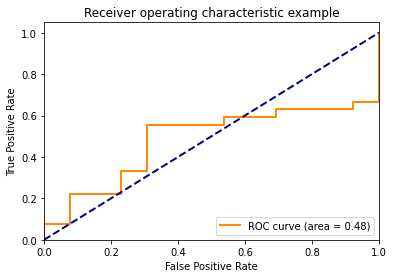

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


val start
val start
val start
val start
val start
val start
val start
val start
End of phase: the true positve is 5.0, false positive is 0.0, true negative is 0.0, false negative is 3.0
Roc calculation result: fpr is [0.         0.         0.         0.66666667 0.66666667 1.        ], tpr is [0.  0.2 0.8 0.8 1.  1. ]
fpr is [0.         0.         0.         0.66666667 0.66666667 1.        ], type is float64, tpr is [0.  0.2 0.8 0.8 1.  1. ], type is <class 'numpy.ndarray'>


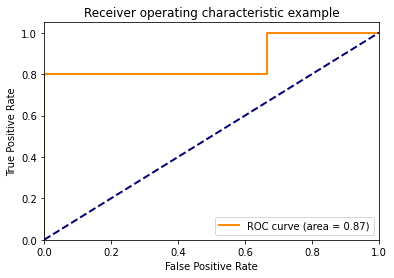

better epoch_phase_acc is 0.625

Epoch 1/2
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
train start
End of phase: the true positve is 27.0, false positive is 0.0, true negative is 0.0, false negative is 13.0
Roc calculation result: fpr is [0.         0.         0.         0.23076923 0.23076923 0.30769231
 0.30769231 0.46153846 0.46153846 0.53846154 0.53846154 0.69230769
 0.69230769 0.76923077 0.76923077 0.84615385 0.84615385 0.92307692
 0.92307692 1.        ], tpr is [0.         0.03703704 0.51851852 0.51851852 0.55555556 0.55555556
 0.62962963 0.62962963 0.66666667 0.66666667 0.7037037  0.7037037
 0.77777778 0.7

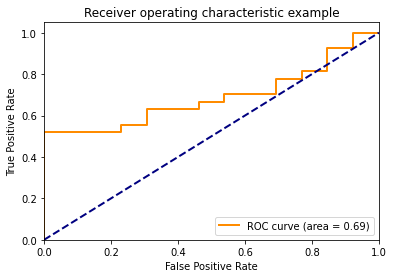

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


val start
val start
val start
val start
val start
val start
val start
val start
End of phase: the true positve is 5.0, false positive is 0.0, true negative is 0.0, false negative is 3.0
Roc calculation result: fpr is [0.         0.         0.         0.66666667 0.66666667 1.        ], tpr is [0.  0.2 0.8 0.8 1.  1. ]
fpr is [0.         0.         0.         0.66666667 0.66666667 1.        ], type is float64, tpr is [0.  0.2 0.8 0.8 1.  1. ], type is <class 'numpy.ndarray'>


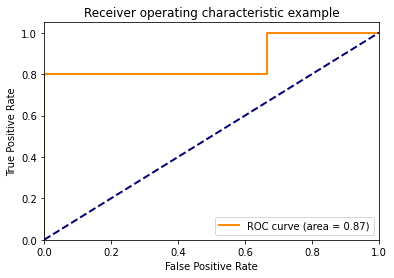


Training complete in 0m 42s
Best val Acc: 0.625000


In [ ]:
current_time = datetime.datetime.now().strftime("%m%d-%H%M")
print(current_time)
log_dir = 'logs/learning_rate/' + current_time +'/Attention_Lenet/lr=5e-8'
summary_writer = tf.summary.create_file_writer(log_dir)
model = attention_lenet()
model = model.to(cuda)
optimizer = optim.Adam(model.parameters(), lr=5e-8, betas=(0.9, 0.999), weight_decay=0.001)

return_model = train_attention(model, optimizer, train_dataloader, val_dataloader, summary_writer, num_epochs=30)
del return_model

### lr=5e-7

In [ ]:
log_dir = 'logs/learning_rate/' + current_time +'/Attention_Lenet/lr=5e-7'
summary_writer = tf.summary.create_file_writer(log_dir)
model = attention_lenet()
model = model.to(cuda)
optimizer = optim.Adam(model.parameters(), lr=5e-7, betas=(0.9, 0.999), weight_decay=0.001)

return_model = train_attention(model, optimizer, train_dataloader, val_dataloader, summary_writer, num_epochs=30)
del return_model

### lr=5e-6

In [ ]:
log_dir = 'logs/learning_rate/' + current_time +'/Attention_Lenet/lr=5e-6'
summary_writer = tf.summary.create_file_writer(log_dir)
model = attention_lenet()
model = model.to(cuda)
optimizer = optim.Adam(model.parameters(), lr=5e-6, betas=(0.9, 0.999), weight_decay=0.001)

return_model = train_attention(model, optimizer, train_dataloader, val_dataloader, summary_writer, num_epochs=30)
del return_model

### lr=5e-5

In [ ]:
log_dir = 'logs/learning_rate/' + current_time +'/Attention_Lenet/lr=5e-5'
summary_writer = tf.summary.create_file_writer(log_dir)
model = attention_lenet()
model = model.to(cuda)
optimizer = optim.Adam(model.parameters(), lr=5e-5, betas=(0.9, 0.999), weight_decay=0.001)

return_model = train_attention(model, optimizer, train_dataloader, val_dataloader, summary_writer, num_epochs=30)
del return_model

### lr=5e-3

In [ ]:
log_dir = 'logs/learning_rate/' + current_time +'/Attention_Lenet/lr=5e-3'
summary_writer = tf.summary.create_file_writer(log_dir)
model = attention_lenet()
model = model.to(cuda)
optimizer = optim.Adam(model.parameters(), lr=5e-3, betas=(0.9, 0.999), weight_decay=0.001)

return_model = train_attention(model, optimizer, train_dataloader, val_dataloader, summary_writer, num_epochs=30)
del return_model

## Tensorboard

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
# %reload_ext tensorboard
%tensorboard --logdir logs/learning_rate/0427-2004/

## Full training

In [ ]:
current_time = datetime.datetime.now().strftime("%m%d-%H%M")
log_dir = 'logs/full_epochs/' + current_time +'/Attention_Lenet/lr=5e-5'
summary_writer = tf.summary.create_file_writer(log_dir)
model = attention_lenet()
model = model.to(cuda)
optimizer = optim.Adam(model.parameters(), lr=5e-5, betas=(0.9, 0.999), weight_decay=0.001)

return_model = train_attention(model, optimizer, train_dataloader, val_dataloader, summary_writer, num_epochs=260)

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
# %reload_ext tensorboard
%tensorboard --logdir logs/full_epochs/0427-1810

## Test

In [ ]:
hyper_parameters = {
    # Training Control Parameters
    
    # Dataset Parameters
    'max_bag_size': 200,
    'dataset_max_size': None,
    'with_data_augmentation': False,
    # 'with_tensorboard': not args.no_tensorboard,
    'seed': 123,
    # 'val_size': 0.15,
    # 'test_size': 0,
    'val_size': 0.02,
    'test_size': 0.95,
}

logger = None
input_width = 224
train_dataset, val_dataset, test_dataset, whole_cases_ids, whole_indexes, whole_dataset = build_datasets(source_slides_folders=slides_folders,
                                                              model_input_width=input_width,
                                                              hyper_parameters=hyper_parameters,
                                                              logger=logger)
N_PROCESSES = 5
def to_dataloader(dataset, for_training):
    assert isinstance(dataset, Dataset) or isinstance(dataset, torch.utils.data.Subset)
    return torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=for_training, num_workers=N_PROCESSES)

train_dataloader = to_dataloader(train_dataset, True)
val_dataloader = to_dataloader(val_dataset, False) if len(val_dataset) else None
test_dataloader = to_dataloader(test_dataset, False) if len(test_dataset) else None

In [ ]:
train_carcinoma = 0
train_non_carcinoma = 0
try:
  for batch_idx, (data, bag_label) in enumerate(train_dataloader):
    if bag_label == torch.Tensor([0]):
      train_carcinoma += 1
    else:
      train_non_carcinoma += 1
  print("There are %d carcinoma and %d non-carcinoma samples in the training set" %(train_carcinoma, train_non_carcinoma))
except TypeError:
  print("Nan")

val_carcinoma = 0
val_non_carcinoma = 0
try:
  for batch_idx, (data, bag_label) in enumerate(val_dataloader):
    if bag_label == torch.Tensor([0]):
      val_carcinoma += 1
    else:
      val_non_carcinoma += 1
  print("There are %d carcinoma and %d non-carcinoma samples in the validation set" %(val_carcinoma, val_non_carcinoma))
except TypeError:
  print("Nan")

test_carcinoma = 0
test_non_carcinoma = 0
try:
  for batch_idx, (data, bag_label) in enumerate(test_dataloader):
    if bag_label == torch.Tensor([0]):
      test_carcinoma += 1
    else:
      test_non_carcinoma += 1
  print("There are %d carcinoma and %d non-carcinoma samples in the test set" %(test_carcinoma, test_non_carcinoma))
except TypeError:
  print("Nan")

In [ ]:
final = test(return_model, optimizer, test_dataloader)

# 4.Attention-MIL (Resnet)

## Train and test function

In [ ]:
def train_attention(model, optimizer, train_loader, val_loader, writer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_size = train_loader.dataset.__len__()
    val_size = val_loader.dataset.__len__()
    print(f"the number of training sample is {train_size}, the number of valisation sample is {val_size}")
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        expect_fpr = np.zeros((num_epochs, 1))
        expect_tpr = np.zeros((num_epochs, 1))
        roc_fpr = np.zeros((3, num_epochs))
        roc_tpr = np.zeros((3, num_epochs))

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            train_loss = 0.
            train_error = 0.
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader

            # running_loss = 0.0
            # running_corrects = 0
            # dataset_size_count = 0

            true_positve = 0.0
            false_positive = 0.0
            true_negative = 0.0
            false_negative = 0.0
            y_true = []
            y_predict = []

            # Iterate over data.
            for batch_idx, (data, bag_label) in enumerate(dataloader):
            # for inputs, labels in dataloader:
                print(phase + " start")
                # dataset_size_count += data.shape[0]
                # # zero the parameter gradients
                optimizer.zero_grad()

                data, bag_label = data.cuda(), bag_label.cuda()
                # data, bag_label = data.to(dev), bag_label.to(dev)
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    # calculate loss and metrics
                    # loss, _, Y_prob_roc = model.calculate_objective(data, bag_label)
                    # train_loss += loss.data[0].cpu().float()

                    # error, _ = model.calculate_classification_error(data, bag_label)
                    # train_error += error

                    loss, _, Y_prob_roc, error, _ = model.calculate_classification_error_and_objective(data, bag_label)
                    # print(f"loss is {loss}")
                    train_loss += torch.squeeze(loss.data[0]).cpu().float()
                    # print(f"trin loss is {train_loss}")
                    train_error += error

                    if bag_label == 1:
                      y_true.append(1)
                      if error == 0.0:
                        true_positve += 1
                      elif error == 1.0:
                        false_positive += 1
                    elif bag_label == 0:
                      y_true.append(0)
                      if error == 0.0:
                        true_negative += 1
                      elif error == 1.0:
                        false_negative += 1
                    # print(Y_prob_roc)
                    y_predict.append(Y_prob_roc)
                    
                    # print("free memory")
                    del data, bag_label
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

            print(f"End of phase: the true positve is {true_positve}, false positive is {false_positive}, true negative is {true_negative}, false negative is {false_negative}")
            # if phase == 'train':
            #   try:
            #     print(f"Explicit result: fpr is {true_negative/(true_negative + false_positive)}, tpr is {true_positve/(true_positve + false_negative)}")
            #     expect_fpr[epoch] = (true_negative/(true_negative + false_positive))
            #     expect_tpr[epoch] = (true_positve/(true_positve + false_negative))
            #     print(f"y_true is {y_true}, y_predict is {y_predict}")
            #   except ZeroDivisionError:
            #     print("zero devision occurs")
            
            fpr, tpr, _ = roc_curve(y_true, y_predict)
            print(f"Roc calculation result: fpr is {fpr}, tpr is {tpr}")
            # roc_fpr[:, epoch] = fpr
            # roc_tpr[:, epoch] = tpr
            roc_auc = auc(fpr, tpr)
            plt.figure()
            lw = 2
            plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
            plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver operating characteristic example')
            plt.legend(loc="lower right")
            plt.show()
            #   # if phase == 'train':
            #   #     scheduler.step()

            # dataset_sizes = dataloader.dataset.__len__()
            # epoch_loss = running_loss / dataset_sizes
            # # epoch_acc = running_corrects.double() / dataset_sizes
            # epoch_acc = running_corrects / dataset_size_count
            
            # # print('Phase {}'.format(phase))
            # # print("Loss: ")
            # # print(train_loss)
            # # print("Error: ")
            # # print(train_error)

            # # print('{} Loss: {:.4f} error: {:.4f} by Size: {:.4f}'.format(
            # #     phase, train_loss, train_error, dataset_sizes))
            epoch_phase_acc = 1 - (train_error / dataloader.dataset.__len__())

            # deep copy the model
            if phase == 'val':
              epoch_phase_acc = 1 - (train_error / dataloader.dataset.__len__())
              if epoch_phase_acc > best_acc:
                print(f"better epoch_phase_acc is {epoch_phase_acc}")
                best_acc = epoch_phase_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            # print(f"train loss before {train_loss}")
            # train_loss = torch.squeeze(train_loss)
            # print(f"train loss after {train_loss}")
            with writer.as_default():
              if phase == 'val':
                tf.summary.scalar('Loss/Validation', train_loss, step=epoch)
                tf.summary.scalar('Error/Validation', train_error, step=epoch)
              else:
                tf.summary.scalar('Loss/Train', train_loss, step=epoch)
                tf.summary.scalar('Error/Train', train_error, step=epoch)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    writer.close()
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model

In [ ]:
def test(model, optimizer, test_loader):
    since = time.time()
    test_size = test_loader.dataset.__len__()
    print(f"the number of test sample is {test_size}")


    # Test phase

    train_error = 0.0
    true_positve = 0.0
    false_positive = 0.0
    true_negative = 0.0
    false_negative = 0.0
    y_true = []
    y_predict = []
    for batch_idx, (data, bag_label) in enumerate(test_loader):
        print("test start")
        optimizer.zero_grad()
        data, bag_label = data.cuda(), bag_label.cuda()
        with torch.no_grad():
            loss, _, Y_prob_roc, error, _ = model.calculate_classification_error_and_objective(data, bag_label)
            train_error += error
            if bag_label == 1:
              y_true.append(1)
              if error == 0.0:
                true_positve += 1
              elif error == 1.0:
                false_positive += 1
            elif bag_label == 0:
              y_true.append(0)
              if error == 0.0:
                true_negative += 1
              elif error == 1.0:
                false_negative += 1
            # print(Y_prob_roc)
            y_predict.append(Y_prob_roc)

            # print("free memory")
            del data, bag_label
    print(f"End of phase: the true positve is {true_positve}, false positive is {false_positive}, true negative is {true_negative}, false negative is {false_negative}")
    fpr, tpr, _ = roc_curve(y_true, y_predict)
    print(f"Roc calculation result: fpr is {fpr}, tpr is {tpr}")
    # roc_fpr[:, epoch] = fpr
    # roc_tpr[:, epoch] = tpr
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    test_acc = 1 - (train_error / test_loader.dataset.__len__())

    time_elapsed = time.time() - since
    print('Test complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Test Acc: {:4f}'.format(test_acc))
    # load best model weights
    # model.load_state_dict(best_model_wts)
    
    return model

## Dataset split

In [ ]:
hyper_parameters = {
    # Training Control Parameters
    
    # Dataset Parameters
    'max_bag_size': 200,
    'dataset_max_size': None,
    'with_data_augmentation': False,
    # 'with_tensorboard': not args.no_tensorboard,
    'seed': 123,
    'val_size': 0.15,
    'test_size': 0,
    # 'val_size': 0.02,
    # 'test_size': 0.95,
}

logger = None
input_width = 224
train_dataset, val_dataset, test_dataset, whole_cases_ids, whole_indexes, whole_dataset = build_datasets(source_slides_folders=slides_folders,
                                                              model_input_width=input_width,
                                                              hyper_parameters=hyper_parameters,
                                                              logger=logger)
N_PROCESSES = 5
def to_dataloader(dataset, for_training):
    assert isinstance(dataset, Dataset) or isinstance(dataset, torch.utils.data.Subset)
    return torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=for_training, num_workers=N_PROCESSES)

train_dataloader = to_dataloader(train_dataset, True)
val_dataloader = to_dataloader(val_dataset, False) if len(val_dataset) else None
test_dataloader = to_dataloader(test_dataset, False) if len(test_dataset) else None

In [ ]:
train_carcinoma = 0
train_non_carcinoma = 0
try:
  for batch_idx, (data, bag_label) in enumerate(train_dataloader):
    if bag_label == torch.Tensor([0]):
      train_carcinoma += 1
    else:
      train_non_carcinoma += 1
  print("There are %d carcinoma and %d non-carcinoma samples in the training set" %(train_carcinoma, train_non_carcinoma))
except TypeError:
  print("Nan")

val_carcinoma = 0
val_non_carcinoma = 0
try:
  for batch_idx, (data, bag_label) in enumerate(val_dataloader):
    if bag_label == torch.Tensor([0]):
      val_carcinoma += 1
    else:
      val_non_carcinoma += 1
  print("There are %d carcinoma and %d non-carcinoma samples in the validation set" %(val_carcinoma, val_non_carcinoma))
except TypeError:
  print("Nan")

test_carcinoma = 0
test_non_carcinoma = 0
try:
  for batch_idx, (data, bag_label) in enumerate(test_dataloader):
    if bag_label == torch.Tensor([0]):
      test_carcinoma += 1
    else:
      test_non_carcinoma += 1
  print("There are %d carcinoma and %d non-carcinoma samples in the test set" %(test_carcinoma, test_non_carcinoma))
except TypeError:
  print("Nan")

## Model

In [ ]:
class attention_resnet(nn.Module):
    def __init__(self,output_layer = None):
        super().__init__()
        self.pretrained = models.resnet18(pretrained=True)
        self.output_layer = output_layer
        self.layers = list(self.pretrained._modules.keys())
        self.layer_count = 0
        for l in self.layers:
            if l != self.output_layer:
                self.layer_count += 1
            else:
                break
        for i in range(1,len(self.layers)-self.layer_count):
            self.dummy_var = self.pretrained._modules.pop(self.layers[-i])
        
        self.net = nn.Sequential(self.pretrained._modules)
        self.pretrained = None

        self.L = 500
        self.D = 128
        self.K = 1

# N, 512, 7, 7

        self.feature_extractor_attention = nn.Sequential(
            nn.Linear(512 * 7 * 7, self.L),
            nn.ReLU(),
        )

        self.attention = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Tanh(),
            nn.Linear(self.D, self.K)
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.L*self.K, 1),
            nn.Sigmoid()
        )

    def forward(self,x):
        x = x.squeeze(0)
        x = self.net(x)
        # print("x size 1")
        # print(x.size())
        x = x.view(-1, 512 * 7 * 7)

        H = self.feature_extractor_attention(x)

        A = self.attention(H)  # NxK
        A = torch.transpose(A, 1, 0)  # KxN
        A = F.softmax(A, dim=1)  # softmax over N

        M = torch.mm(A, H)  # KxL

        Y_prob = self.classifier(M)
        Y_hat = torch.ge(Y_prob, 0.5).float()

        return Y_prob, Y_hat, A
    
    # AUXILIARY METHODS
    def calculate_classification_error(self, X, Y):
        Y = Y.float()
        _, Y_hat, _ = self.forward(X)
        error = 1. - Y_hat.eq(Y).cpu().float().mean().item()

        return error, Y_hat

    def calculate_objective(self, X, Y):
        Y = Y.float()
        Y_prob, _, A = self.forward(X)
        Y_prob = torch.clamp(Y_prob, min=1e-5, max=1. - 1e-5)
        neg_log_likelihood = -1. * (Y * torch.log(Y_prob) + (1. - Y) * torch.log(1. - Y_prob))  # negative log bernoulli

        return neg_log_likelihood, A
    
    # AUXILIARY METHODS
    def calculate_classification_error_and_objective(self, X, Y):
        Y = Y.float()
        Y_prob_roc, Y_hat, A = self.forward(X)
        error = 1. - Y_hat.eq(Y).cpu().float().mean().item()
        Y_prob = torch.clamp(Y_prob_roc, min=1e-5, max=1. - 1e-5)
        neg_log_likelihood = -1. * (Y * torch.log(Y_prob) + (1. - Y) * torch.log(1. - Y_prob))  # negative log bernoulli


        return neg_log_likelihood, A, Y_prob_roc.detach().cpu().float(), error, Y_hat

In [ ]:
model = attention_resnet(output_layer = 'layer4')
cuda = torch.device('cuda:0')
model = model.to(cuda)
summary(model,input_size=(3, 224, 224))


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64

In [ ]:
print(model)
del model

attention_resnet(
  (pretrained): None
  (dummy_var): AdaptiveAvgPool2d(output_size=(1, 1))
  (net): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fa

## Learning rate study

### lr=5e-8

In [ ]:
current_time = datetime.datetime.now().strftime("%m%d-%H%M")
print(current_time)
log_dir = 'logs/learning_rate/' + current_time +'/Attention_Resnet/lr=5e-8'

summary_writer = tf.summary.create_file_writer(log_dir)
model = attention_resnet(output_layer = 'layer4')
model = model.to(cuda)
optimizer = optim.Adam(model.parameters(), lr=5e-8, betas=(0.9, 0.999), weight_decay=0.001)

return_model = train_attention(model, optimizer, train_dataloader, val_dataloader, summary_writer, num_epochs=30)
del return_model

### lr=5e-7

In [ ]:
log_dir = 'logs/learning_rate/' + current_time +'/Attention_Resnet/lr=5e-7'
summary_writer = tf.summary.create_file_writer(log_dir)
model = attention_resnet(output_layer = 'layer4')
model = model.to(cuda)
optimizer = optim.Adam(model.parameters(), lr=5e-7, betas=(0.9, 0.999), weight_decay=0.001)

return_model = train_attention(model, optimizer, train_dataloader, val_dataloader, summary_writer, num_epochs=30)
del return_model

### lr=5e-6

In [ ]:
log_dir = 'logs/learning_rate/' + current_time +'/Attention_Resnet/lr=5e-6'
summary_writer = tf.summary.create_file_writer(log_dir)
model = attention_resnet(output_layer = 'layer4')
model = model.to(cuda)
optimizer = optim.Adam(model.parameters(), lr=5e-6, betas=(0.9, 0.999), weight_decay=0.001)

return_model = train_attention(model, optimizer, train_dataloader, val_dataloader, summary_writer, num_epochs=30)
del return_model

### lr=5e-5

In [ ]:
log_dir = 'logs/learning_rate/' + current_time +'/Attention_Resnet/lr=5e-5'
summary_writer = tf.summary.create_file_writer(log_dir)
model = attention_resnet(output_layer = 'layer4')
model = model.to(cuda)
optimizer = optim.Adam(model.parameters(), lr=5e-5, betas=(0.9, 0.999), weight_decay=0.001)

return_model = train_attention(model, optimizer, train_dataloader, val_dataloader, summary_writer, num_epochs=30)
del return_model

### lr=5e-3

In [ ]:
log_dir = 'logs/learning_rate/' + current_time +'/Attention_Resnet/lr=5e-3'
summary_writer = tf.summary.create_file_writer(log_dir)
model = attention_resnet(output_layer = 'layer4')
model = model.to(cuda)
optimizer = optim.Adam(model.parameters(), lr=5e-3, betas=(0.9, 0.999), weight_decay=0.001)

return_model = train_attention(model, optimizer, train_dataloader, val_dataloader, summary_writer, num_epochs=30)
del return_model

### Tensorboard

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
# %reload_ext tensorboard
%tensorboard --logdir logs/learning_rate/0427-1624/

## Full epochs Train

In [ ]:
current_time = datetime.datetime.now().strftime("%m%d-%H%M")
print(current_time)
log_dir = 'logs/full_epochs/' + current_time +'/Attention_Resnet/lr=5e-6'
summary_writer = tf.summary.create_file_writer(log_dir)
model = attention_resnet(output_layer = 'layer4')
model = model.to(cuda)
optimizer = optim.Adam(model.parameters(), lr=5e-6, betas=(0.9, 0.999), weight_decay=0.001)

return_model = train_attention(model, optimizer, train_dataloader, val_dataloader, summary_writer, num_epochs=70)

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
# %reload_ext tensorboard
%tensorboard --logdir logs/full_epochs/0427-1721/

## Test

In [ ]:
hyper_parameters = {
    # Training Control Parameters
    
    # Dataset Parameters
    'max_bag_size': 200,
    'dataset_max_size': None,
    'with_data_augmentation': False,
    # 'with_tensorboard': not args.no_tensorboard,
    'seed': 123,
    # 'val_size': 0.15,
    # 'test_size': 0,
    'val_size': 0.02,
    'test_size': 0.95,
}

logger = None
input_width = 224
train_dataset, val_dataset, test_dataset, whole_cases_ids, whole_indexes, whole_dataset = build_datasets(source_slides_folders=slides_folders,
                                                              model_input_width=input_width,
                                                              hyper_parameters=hyper_parameters,
                                                              logger=logger)
N_PROCESSES = 5
def to_dataloader(dataset, for_training):
    assert isinstance(dataset, Dataset) or isinstance(dataset, torch.utils.data.Subset)
    return torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=for_training, num_workers=N_PROCESSES)

train_dataloader = to_dataloader(train_dataset, True)
val_dataloader = to_dataloader(val_dataset, False) if len(val_dataset) else None
test_dataloader = to_dataloader(test_dataset, False) if len(test_dataset) else None

In [ ]:
train_carcinoma = 0
train_non_carcinoma = 0
try:
  for batch_idx, (data, bag_label) in enumerate(train_dataloader):
    if bag_label == torch.Tensor([0]):
      train_carcinoma += 1
    else:
      train_non_carcinoma += 1
  print("There are %d carcinoma and %d non-carcinoma samples in the training set" %(train_carcinoma, train_non_carcinoma))
except TypeError:
  print("Nan")

val_carcinoma = 0
val_non_carcinoma = 0
try:
  for batch_idx, (data, bag_label) in enumerate(val_dataloader):
    if bag_label == torch.Tensor([0]):
      val_carcinoma += 1
    else:
      val_non_carcinoma += 1
  print("There are %d carcinoma and %d non-carcinoma samples in the validation set" %(val_carcinoma, val_non_carcinoma))
except TypeError:
  print("Nan")

test_carcinoma = 0
test_non_carcinoma = 0
try:
  for batch_idx, (data, bag_label) in enumerate(test_dataloader):
    if bag_label == torch.Tensor([0]):
      test_carcinoma += 1
    else:
      test_non_carcinoma += 1
  print("There are %d carcinoma and %d non-carcinoma samples in the test set" %(test_carcinoma, test_non_carcinoma))
except TypeError:
  print("Nan")

In [ ]:
final = test(return_model, optimizer, test_dataloader)